In [18]:
import cv2
from skimage.measure import label, regionprops, regionprops_table
from skimage import measure
import matplotlib.pyplot as plt
import numpy as np
import math
import os
%matplotlib inline
import pandas as pd
import scipy

from scipy import ndimage
from tqdm import tqdm
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error




In [7]:
!pwd

/athena/sablab/scratch/prj4005/Echonet/Notebooks


In [4]:
seg = np.load('../../Outputs/pretrained_segmentation/labels/0X1AECADC95492F71D.npy')
mask = 255 * (seg>0)


FileNotFoundError: [Errno 2] No such file or directory: '../../Outputs/pretrained_segmentation/labels/0X1AECADC95492F71D.npy'

In [10]:
regions = regionprops(mask[0,:,:])
image = mask[0,:,:]


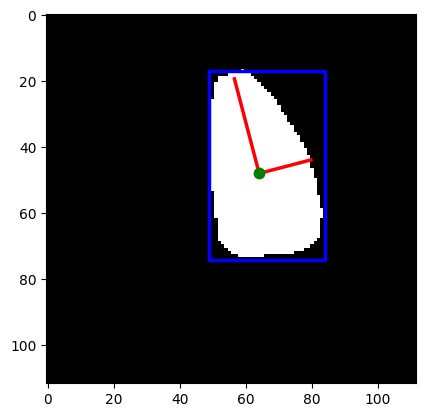

In [11]:
fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)


plt.show()

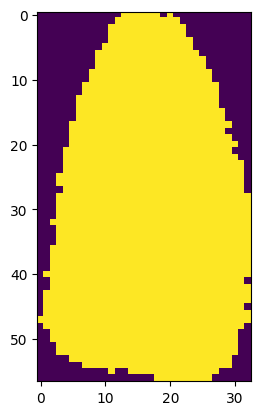

In [20]:
#Rotate the bounding box so major axis is verticla and then crop the image to only have the boudning box
rot = cv2.getRotationMatrix2D((x0,y0),-orientation*180/math.pi,1)
cropped = image[minr:maxr,minc:maxc]
rotated = (ndimage.rotate(cropped, -orientation*180/math.pi)>200)
r1 = rotated[~np.all(rotated== 0, axis=1)]
r2 = r1[:,~np.all(r1== 0, axis=0)]
plt.imshow(r2)
l = r2.shape[0]
w = np.sum(r2,axis=1)/2
vol = np.pi*np.sum(w**2)



In [5]:
def calculate_volume(fname,frames):
    seg = np.load(fname)
    mask = 1*(seg>0)    
    vol = np.zeros(mask.shape[0])
    for i in frames:
        if i < mask.shape[0]:
            regions = regionprops(mask[i,:,:])
            image = mask[i,:,:]
            if len(regions)==0:
                vol[i] = 0
            else:
                props = regions[0]
                orientation = props.orientation
                minr, minc, maxr, maxc = props.bbox
                cropped = image[minr:maxr,minc:maxc]
                rotated = (ndimage.rotate(cropped, -orientation*180/math.pi))
                r1 = rotated[~np.all(rotated== 0, axis=1)]
                r2 = r1[:,~np.all(r1== 0, axis=0)]
                w = np.sum(r2,axis=1)/2
                vol[i] = np.pi*np.sum(w**2)
    return vol








In [3]:
directory = '/athena/sablab/scratch/prj4005/Outputs/Pretrained_segmentation_all'
df_size = pd.read_csv(os.path.join(directory,'size.csv'))

In [7]:

df = pd.DataFrame(columns=['Filename','Frame','Size','Volume','Computer Small','Computer Large'])
for filename in tqdm(df_size['Filename'].unique()):
    filepath = os.path.join(directory,'labels',filename[:-3]+'npy')
    if os.path.exists(filepath):
        cur = df_size[df_size['Filename']==filename]
        size = cur['Size'].values
        systole = set(np.argwhere(cur['ComputerSmall'].values==1).flatten())
        trim_min = sorted(size)[round(len(size) ** 0.05)]
        trim_max = sorted(size)[round(len(size) ** 0.95)]
        trim_range = trim_max - trim_min
        diastole = set(scipy.signal.find_peaks(size, distance=20, prominence=(0.50 * trim_range))[0])
        vol = calculate_volume(filepath,diastole.union(systole))
        for i in range(len(vol)):
            if i in diastole or i in systole:
                df = df.append({'Filename':filename[:-3]+'avi','Frame':i,'Size':size[i], 'Volume':vol[i],'Computer Small':1 if i in systole else 0,'Computer Large':1 if i in diastole else 0},ignore_index=True)
    else:
        print(filename)

df.to_csv(os.path.join(directory,'volume.csv'),index=False)



100%|██████████| 8796/8796 [21:03<00:00,  6.96it/s]


In [4]:
df = pd.read_csv(os.path.join(directory,'volume.csv'))

In [6]:
df_merged = pd.merge(df,df_size,how='left',on=['Filename','Frame'])

In [7]:
df_ef = pd.DataFrame(columns=['FileName','EDF','ESV','EF'])
for file in df['Filename'].unique():
    edv = df.loc[(df['Filename']==file) & (df['Computer Large']==1),'Volume'].mean()
    esv = df.loc[(df['Filename']==file) & (df['Computer Small']==1),'Volume'].mean()
    ef = (edv-esv)/edv
    df_ef = df_ef.append({'FileName':file[:-4],'EDF':edv,'ESV':esv,'EF':ef},ignore_index=True)
df_ef.to_csv(os.path.join(directory,'seg_ef.csv'),index=False)



In [8]:
df_ef = pd.read_csv(os.path.join(directory,'seg_ef.csv'))

In [9]:
df_ef.head()

,FileName,EDF,ESV,EF
0,0X100009310A3BD7FC,26869.256568,6950.773746,0.741311
1,0X1002E8FBACD08477,18125.942414,7746.185736,0.572646
2,0X1005D03EED19C65B,13505.445018,5844.736782,0.567231
3,0X10075961BC11C88E,18934.640723,8792.532439,0.535638
4,0X10094BA0A028EAC3,62753.313255,40120.494381,0.360663


In [5]:
Raw_data = pd.read_csv('/athena/sablab/scratch/dataset/echonet/FileList.csv', delimiter=',')

In [17]:
Raw_data.head()

,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split
0,0X100009310A3BD7FC,78.498406,14.881368,69.210534,112,112,50,174,VAL
1,0X1002E8FBACD08477,59.101988,40.383876,98.742884,112,112,50,215,TRAIN
2,0X1005D03EED19C65B,62.363798,14.267784,37.909734,112,112,50,104,TRAIN
3,0X10075961BC11C88E,54.545097,33.143084,72.914210,112,112,55,122,TRAIN
4,0X10094BA0A028EAC3,24.887742,127.581945,169.855024,112,112,52,207,VAL


In [10]:
df_merge_ef = pd.merge(Raw_data,df_ef,how='right',on=['FileName'])

In [11]:
df_merge_ef.head()
df_merge_ef.to_csv(os.path.join(directory,'merge_ef.csv'),index=False)

In [ ]:
df_merge_ef = pd.read_csv(os.path.join(directory,'merge_ef.csv'))

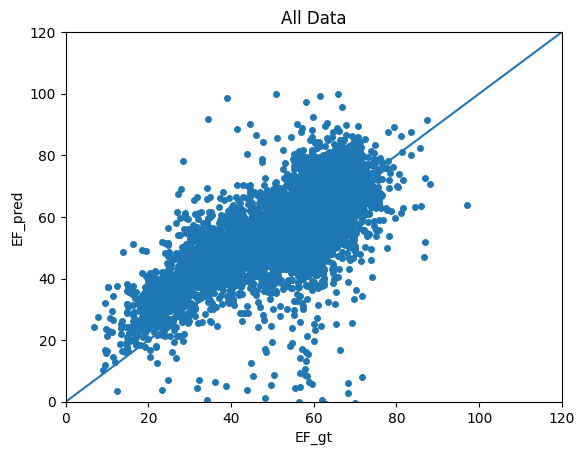

In [12]:
fig,ax = plt.subplots(1)
ax.plot(df_merge_ef['EF_x'],df_merge_ef['EF_y']*100,'o',markersize=4)
ax.set_xlim(0,120)
ax.set_ylim(0,120)
ax.set_xlabel('EF_gt')
ax.set_ylabel('EF_pred')
ax.set_title('All Data')
ax.axline((0, 0), slope=1)

In [13]:
df_merge_ef = pd.merge(Raw_data,df_ef,how='right',on=['FileName'])
Combined_df = df_merge_ef
Combined_df.EF_y = Combined_df.EF_y*100
Combined_df = Combined_df[Combined_df['EF_y'].notna()]
Combined_df = Combined_df[Combined_df['EF_y']>0]

In [14]:
np.sum(Combined_df.EF_y <0)

0

In [15]:
Combined_train = Combined_df[Combined_df['Split'] == 'TRAIN']
Combined_val = Combined_df[Combined_df['Split'] == 'VAL']
Combined_test = Combined_df[Combined_df['Split'] == 'TEST']

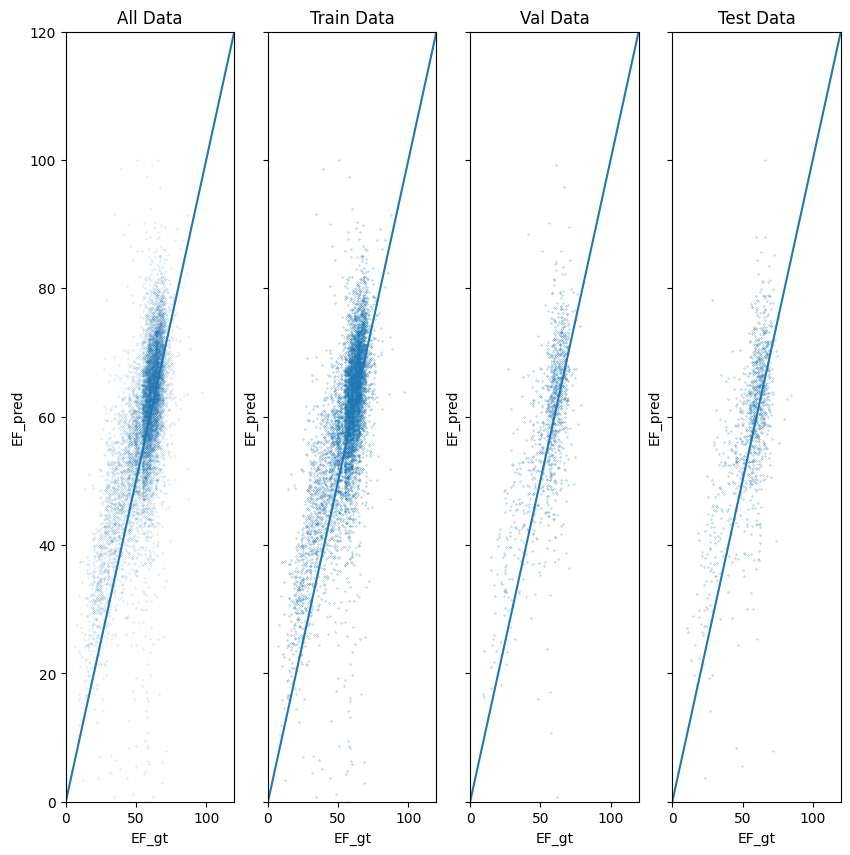

In [16]:
fig,ax = plt.subplots(1,4,sharex=True,sharey=True,figsize=(10,10))
ax[0].plot(Combined_df['EF_x'],Combined_df['EF_y'],'o',markersize=0.1)
ax[0].set_xlim(0,120)
ax[0].set_ylim(0,120)
ax[0].set_xlabel('EF_gt')
ax[0].set_ylabel('EF_pred')
ax[0].set_title('All Data')
ax[0].axline((0, 0), slope=1)
ax[1].plot(Combined_train['EF_x'],Combined_train['EF_y'],'o',markersize=0.2)
ax[1].set_xlabel('EF_gt')
ax[1].set_ylabel('EF_pred')
ax[1].set_title('Train Data')
ax[1].axline((0, 0), slope=1)
ax[2].plot(Combined_val['EF_x'],Combined_val['EF_y'],'o',markersize=0.2)
ax[2].set_xlabel('EF_gt')
ax[2].set_ylabel('EF_pred')
ax[2].set_title('Val Data')
ax[2].axline((0, 0), slope=1)
ax[3].plot(Combined_test['EF_x'],Combined_test['EF_y'],'o',markersize=0.2)
ax[3].set_xlabel('EF_gt')
ax[3].set_ylabel('EF_pred')
ax[3].set_title('Test Data')
ax[3].axline((0, 0), slope=1)

In [17]:
mse = mean_squared_error(Combined_df['EF_x'],Combined_df['EF_y'])
mse_train = mean_squared_error(Combined_train['EF_x'],Combined_train['EF_y'])
mse_test = mean_squared_error(Combined_test['EF_x'],Combined_test['EF_y'])
mse_val = mean_squared_error(Combined_val['EF_x'],Combined_val['EF_y'])
print('RMSE for all data is: ', np.sqrt(mse))
print('RMSE for train data is: ', np.sqrt(mse_train))
print('RMSE for test data is: ', np.sqrt(mse_test))
print('RMSE for val data is: ', np.sqrt(mse_val))


RMSE for all data is:  9.62824530248663
RMSE for train data is:  9.515708007836453
RMSE for test data is:  9.931249329832
RMSE for val data is:  9.974069450076891


In [66]:
r_squared = r2_score(Combined_df['EF_x'],Combined_df['EF_y'])
r_squared_train = r2_score(Combined_train['EF_x'],Combined_train['EF_y'])
r_squared_test = r2_score(Combined_test['EF_x'],Combined_test['EF_y'])
r_squared_val = r2_score(Combined_val['EF_x'],Combined_val['EF_y'])
r = np.sqrt(r_squared)
r_train = np.sqrt(r_squared_train)
r_test = np.sqrt(r_squared_test)
r_val = np.sqrt(r_squared_val)
print('R2 for all data is: ', r_squared)
print('R2 for train data is: ', r_squared_train)
print('R2 for test data is: ', r_squared_test)
print('R2 for val data is: ', r_squared_val)
print('R for all data is: ', r)
print('R for train data is: ', r_train)
print('R for test data is: ', r_test)
print('R for val data is: ', r_val)


R2 for all data is:  0.38438582481706907
R2 for train data is:  0.4025981906681434
R2 for test data is:  0.3154337222390521
R2 for val data is:  0.34189092117768527
R for all data is:  0.6199885682954719
R for train data is:  0.6345062573908499
R for test data is:  0.5616348655835498
R for val data is:  0.5847143928258354


In [19]:
mae = mean_absolute_error(Combined_df['EF_x'],Combined_df['EF_y'])
mae_train = mean_absolute_error(Combined_train['EF_x'],Combined_train['EF_y'])
mae_test = mean_absolute_error(Combined_test['EF_x'],Combined_test['EF_y'])
mae_val = mean_absolute_error(Combined_val['EF_x'],Combined_val['EF_y'])
print('MAE for all data is: ', mae)
print('MAE for train data is: ', mae_train)
print('MAE for test data is: ', mae_test)
print('MAE for val data is: ', mae_val)

MAE for all data is:  7.1943616085960205
MAE for train data is:  7.113365907499288
MAE for test data is:  7.502605509254537
MAE for val data is:  7.365812181076993
